In [3]:
import astropy.units as u
import numpy as np
from BDFit import StarFit, find_bands, provide_phot
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os
from astropy.coordinates import SkyCoord, Galactocentric
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.visualization import LogStretch, ImageNormalize, AsymmetricPercentileInterval, LinearStretch

In [4]:
s = StarFit('sonora_bobcat')

Library path: /nvme/scratch/work/tharvey/brown_dwarfs/models
Warning! F410M found in multiple instruments. Keeping first, which is NIRCam. Provide instrument.band in dictionary to override this.
Total models: 1208


In [5]:
cat_path = '/nvme/scratch/work/tharvey/catalogs/UNCOVER_DR3_LW_SUPER_catalog.fits'

table = Table.read(cat_path)

bands = find_bands(table, flux_wildcard=f'f_*')

bands_to_remove =  ['f105w', 'f125w', 'f140w', 'f160w', 'alma']
for band in bands_to_remove:
    bands.remove(band)

flux, error = provide_phot(bands=bands, flux_wildcard='f_*', error_wildcard='e_*', table=table, flux_unit=u.nJy)
# unit is 10*nJy
flux *= 10
error *= 10

s.fit_catalog(fnu=flux, efnu=error, bands=[band.upper() for band in bands], catalogue_ids=table['id'])

Warning! Assuming F435W is the same as ACS_WFC.F435W
Warning! Assuming F606W is the same as ACS_WFC.F606W
Warning! Assuming F814W is the same as ACS_WFC.F814W
Fitting with sonora_bobcat libraries with 1208 templates.
Fitting 23 bands: ['ACS_WFC.F435W', 'ACS_WFC.F606W', 'ACS_WFC.F814W', 'F070W', 'F090W', 'F115W', 'F140M', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M', 'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F360M', 'F410M', 'F430M', 'F444W', 'F460M', 'F480M']
(74020, 23) (1208, 23) (1208, 23) (23, 1208) (74020, 1208)


Calculating chi2 for all templates...: 100%|██████████| 1208/1208 [00:31<00:00, 38.40it/s]
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1435: RuntimeWarning: All-NaN slice encountered
  star_min_chi2 = np.nanmin(star_chi2, axis=1)


{'subset': None,
 'star_tnorm': array([[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [6.05964317e+06, 5.07147837e+06, 4.80008411e+06, ...,
         8.03169248e-02, 8.56930429e-02, 9.07429280e-02],
        [3.32926033e+05, 6.66393156e+05, 8.07557997e+04, ...,
         9.07106266e-04, 8.44414977e-04, 8.40173789e-04],
        [2.50922783e+05, 6.91158183e+05, 6.18757231e+04, ...,
         9.43045776e-04, 8.87718533e-04, 8.77728627e-04]]),
 'star_chi2': array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        n

In [4]:
# Reduced chi2 less than 1, S/N in any 3 bands greater than 5, and all 27 filters used

mask = (s.star_min_chinu < 3) & (np.sum(flux.value/error.value > 8, axis=1) > 3) & (s.nusefilt > 15)
ids = np.arange(len(s.star_min_chinu))[mask]
print(len(ids))
for i in ids:
    s.plot_fit(idx=i, flux_unit=u.nJy)


781


/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1763: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=200)


In [ ]:
galcen_frame = Galactocentric

coord = SkyCoord(ra=table['ra'][mask], dec=table['dec'][mask], unit=(u.deg, u.deg), distance=12.3*u.kpc)
dummy = SkyCoord(ra=table['ra'][mask], dec=table['dec'][mask], unit=(u.deg, u.deg), distance=0*u.kpc)

coords_galactocentric = coord.transform_to(galcen_frame)
coords_galactocentric_dummy = dummy.transform_to(galcen_frame)

coords_galactocentric_dummy.x, coords_galactocentric.x
coords_galactocentric_dummy.y, coords_galactocentric.y
coords_galactocentric_dummy.z, coords_galactocentric.z
            

(<Quantity [0.0208, 0.0208, 0.0208, 0.0208, 0.0208, 0.0208] kpc>,
 <Quantity [-12.13949432, -12.14045294, -12.14044859, -12.1404455 ,
            -12.14043878, -12.13881896] kpc>)

/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:2353: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if idxs == 'all':


UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

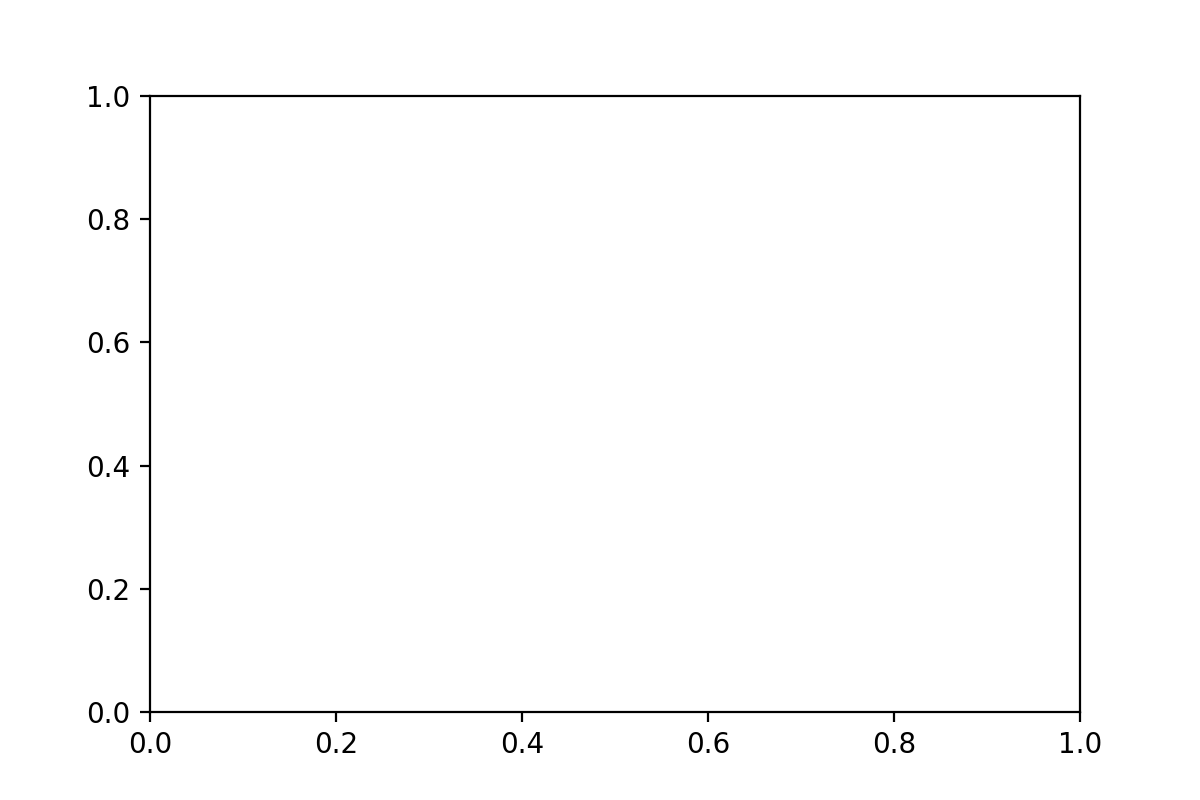

In [ ]:
#%matplotlib ipympl

ras = table['ra'][mask]
decs = table['dec'][mask]

s.plot_brown_dwarf_locations(idxs=ids, ra=ras, dec=decs, coord_system='galactocentric', plot_3d=False)

/raid/scratch/data/jwst/UNCOVER/UNCOVER_DR3/abell2744clu-grizli-v7.2-f162m-clear_drc_sci.fits


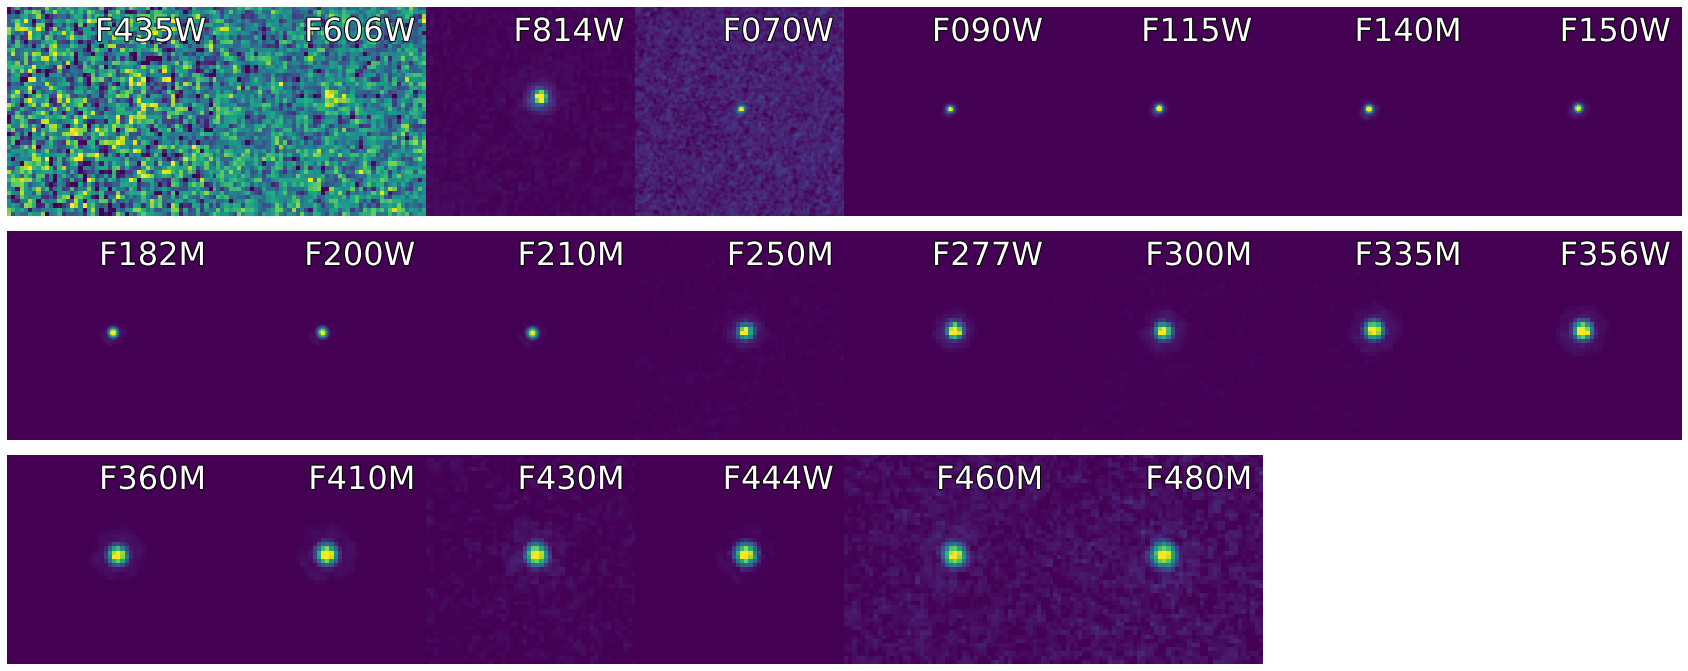

In [62]:
%matplotlib inline

image_folder = '/raid/scratch/data/jwst/UNCOVER/UNCOVER_DR3'

cutout_size_as = 2 * u.arcsec
id = 29562
scale = LinearStretch()

nrows = 3
fig, ax = plt.subplots(nrows, int(np.ceil(len(bands)/nrows)), figsize=(4*len(bands)//nrows, 4.12*nrows))

ax = ax.flatten()

def uncover_cutout(band, image_folder):
    image_name = f'{image_folder}/abell2744clu-grizli-v7.2-{band.lower()}-clear_drc_sci.fits'
    alt_image_name = f'{image_folder}/abell2744clu-grizli-v7.0-{band.lower()}_drz_sci.fits'
    alt_image_name2 = f'{image_folder}/abell2744clu-grizli-v7.1-{band.lower()}_drc_sci.fits'

    if os.path.exists(alt_image_name):
        image_name = alt_image_name
    elif os.path.exists(alt_image_name2):
        image_name = alt_image_name2

    if not os.path.exists(image_name):
        print(image_name)
        add = False
        return False, False, add, False, False
    else:
        add = True
    hdu = fits.open(image_name)
    header = hdu[0].header
    wcs_im = WCS(header)
    
    pixel_scale = np.abs(hdu[0].header['CD1_1']) * u.deg
    cutout_size = int(cutout_size_as / pixel_scale)


    ra_coord = table['ra'][table['id'] == id]
    dec_coord = table['dec'][table['id'] == id]
    sky_pos = SkyCoord(ra_coord, dec_coord)                        
    pixel_coords = skycoord_to_pixel(sky_pos, wcs_im)
    x, y = pixel_coords[0][0], pixel_coords[1][0]
    data = np.array(hdu[0].section[int(y-cutout_size/2):int(y+cutout_size/2), int(x-cutout_size/2):int(x+cutout_size/2)])
    # get only middle 10x10 pixels
    data_crop = data[cutout_size//2-5:cutout_size//2+5, cutout_size//2-5:cutout_size//2+5]
    return data, data_crop, add, header, (x, y)

ax_pos = 0
for pos, band in enumerate(bands):

    data, data_crop, add, _, _ = uncover_cutout(band, image_folder)
    if data is False:
        continue

    norm = ImageNormalize(data_crop, stretch=scale, interval=AsymmetricPercentileInterval(1, 98))
    ax[ax_pos].imshow(data, norm=norm, cmap='viridis', origin='lower')
    
    ax[ax_pos].text(0.95, 0.95, band.upper(), color='white', ha='right', va='top', transform=ax[ax_pos].transAxes, fontsize=32,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')])
    
    ax[ax_pos].axis('off')    
    if add:
        ax_pos += 1


for i in range(ax_pos, len(ax)):
    fig.delaxes(ax[i])

# Remove horizontal space between axes
plt.subplots_adjust(hspace=0, wspace=0)

(array(15767.57729711), array(13680.96847658)) [53.47145221 55.64896557]
Distance between the two centroids is 0.12565349827280065 arcsec
Time difference between the two observations is 4627 days
Angular velocity is 0.009918941051251445 arcsec/year
Transverse velocity is 159.8695200821521 km / s


Text(0.05, 0.05, '$\\delta t = 4627 \\ \\mathrm{days}$\n$\\delta \\theta = $$0.126\\mathrm{{}^{\\prime\\prime}}$\n$\\mathrm{v}_{\\mathrm{trans}}=$$160 \\; \\mathrm{km\\,s^{-1}}$')

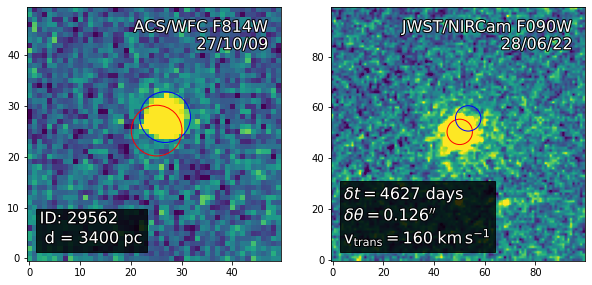

In [78]:
first_band = 'F090W'
second_band = 'F814W'

data_first, _, _, header_first, first_center = uncover_cutout(first_band, image_folder)
data_second, _, _, header_second, second_center = uncover_cutout(second_band, image_folder)

# Get centroid of both

wcs_first = WCS(header_first)
wcs_second = WCS(header_second)


from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg

centroid_first = centroid_2dg(data_first)
centroid_second = centroid_2dg(data_second)

# Convert to sky coordinates

# Need to correct for WCS offsets - first_center and second_center are the cutout centers. Need to calculate positions in full image - i,e centroid_first -middle + first_center

center_first_corr = first_center[0] + centroid_first[0] - np.shape(data_first)[0]//2, first_center[1] + centroid_first[1] - np.shape(data_first)[1]//2
center_second_corr = second_center[0] + centroid_second[0] - np.shape(data_second)[0]//2, second_center[1] + centroid_second[1] - np.shape(data_second)[1]//2



sky_first = wcs_first.pixel_to_world(center_first_corr[0], center_first_corr[1])
sky_second = wcs_second.pixel_to_world(center_second_corr[0], center_second_corr[1])    

centroid_second_on_first = wcs_first.world_to_pixel(sky_second) - np.array(first_center) + np.array(np.shape(data_first))//2

print(wcs_first.world_to_pixel(sky_second), centroid_second_on_first)

# Get distance between the two

distance = sky_first.separation(sky_second)

print(f'Distance between the two centroids is {distance.to(u.arcsec)}')

date_first = header_first['DATE-OBS'] 
date_second = header_second['DATE-OBS']

# Calculate time difference between the two

from datetime import datetime

date_format = '%Y-%m-%d'
date_first = datetime.strptime(date_first, date_format)
date_second = datetime.strptime(date_second, date_format)

time_diff = date_first - date_second 

print(f'Time difference between the two observations is {time_diff.days} days')

print(f'Angular velocity is {distance.to(u.arcsec).value / (time_diff.days / 365.25)} arcsec/year')


distance_physical = 3400 * u.pc 


# Calculate transverse velocity given distance and angular velocity - theta = v*t

projected_distance_physical = distance_physical * distance.to(u.rad)

projected_distance_physical = projected_distance_physical.value * u.pc
time_seconds = time_diff.total_seconds() * u.s

transverse_velocity = projected_distance_physical / time_seconds
print(f'Transverse velocity is {transverse_velocity.to(u.km/u.s)}')

# Make a plot of second on first image

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

norm = ImageNormalize(data_first, stretch=scale, interval=AsymmetricPercentileInterval(1, 98))
ax[1].imshow(data_first, norm=norm, cmap='viridis', origin='lower')

# Show positon of first and second centroid with circle

from matplotlib.patches import Circle

circle = Circle((centroid_first[0], centroid_first[1]), 5, edgecolor='red', facecolor='none')

ax[1].add_patch(circle)

circle = Circle((centroid_second_on_first[0], centroid_second_on_first[1]), 5, edgecolor='blue', facecolor='none')

ax[1].add_patch(circle)

norm = ImageNormalize(data_second, stretch=scale, interval=AsymmetricPercentileInterval(1, 98))
ax[0].imshow(data_second, norm=norm, cmap='viridis', origin='lower')

circle = Circle((centroid_second[0], centroid_second[1]), 5, edgecolor='blue', facecolor='none')

ax[0].add_patch(circle)

centroid_first_on_second = wcs_second.world_to_pixel(sky_first) - np.array(second_center) + np.array(np.shape(data_second))//2

circle = Circle((centroid_first_on_second[0], centroid_first_on_second[1]), 5, edgecolor='red', facecolor='none')

ax[0].add_patch(circle)

# Label with band and date

ax[1].text(0.95, 0.95, f'JWST/NIRCam {first_band.upper()}\n{date_first:%d/%m/%y}', color='white', ha='right', va='top', transform=ax[1].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')])

ax[0].text(0.95, 0.95, f'ACS/WFC {second_band.upper()}\n{date_second:%d/%m/%y}', color='white', ha='right', va='top', transform=ax[0].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')])

ax[0].text(0.05, 0.05, f'ID: {id}\n d = {np.round(distance_physical, 0):latex}', color='white', ha='left', va='bottom', transform=ax[0].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')], bbox=dict(facecolor='black', edgecolor='black', alpha=0.8))

ax[1].text(0.05, 0.05, f'$\delta t = {time_diff.days} \ \mathrm{{days}}$\n$\delta \\theta = ${np.round(distance.to(u.arcsec), 3):latex}\n$\mathrm{{v}}_{{\mathrm{{trans}}}}=${np.round(transverse_velocity.to(u.km/u.s), 0):latex_inline}', color='white', ha='left', va='bottom', transform=ax[1].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')], bbox=dict(facecolor='black', edgecolor='black', alpha=0.8))

In [ ]:
header_first

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                43008                                                  
NAXIS2  =                32768                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =              14081.5 / Pixel coordinate of reference point            
CRPIX2  =              12723.5 / Pixel coordinate of reference point            
CD1_1   = -5.5555555555555E-06 / Coordinate transformation matrix element       
CD2_2   =  5.5555555555555E-06 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

Match known UNCOVER Brown Dwarfs

In [ ]:
names = ['UNCOVER BD1', 'UNCOVER BD2', 'UNCOVER BD3']
coords = ['J00140901-3022126','J00141114-3021585','J00140333-3021217']

coords_ra = [3.537529, 3.546420, 3.513891]
coords_dec = [-30.370169, -30.366245, -30.356024]

for i in range(len(names)):
    test = SkyCoord.from_name(coords[i])
    coords[i] = SkyCoord(ra=coords_ra[i], dec=coords_dec[i], unit=(u.deg, u.deg))
    print(coords[i].to_string('hmsdms'), test.to_string('hmsdms'), coords[i].separation(test).arcsec)

new_skycoord = SkyCoord(ra=[coord.ra.deg for coord in coords], dec=[coord.dec.deg for coord in coords], unit=(u.deg, u.deg))

# Match to catalog

all_catalog = SkyCoord(table['ra'], table['dec'], unit='deg')

idx, sep, _ = new_skycoord.match_to_catalog_sky(all_catalog)

# Closest match is idx[0] with sep[0]   

for i in range(len(names)):
    print(names[i], sep[i].arcsec, table['id'][idx[i]])

00h14m09.00696s -30d22m12.6084s 00h14m09.012s -30d22m12.612s 0.0653252136858905
00h14m11.1408s -30d21m58.482s 00h14m11.1432s -30d21m58.536s 0.0622960607508309
00h14m03.33384s -30d21m21.6864s 00h14m03.3336s -30d21m21.708s 0.021822236594214988
UNCOVER BD1 0.0068337720686782785 44489
UNCOVER BD2 0.0037720809545995645 45661
UNCOVER BD3 0.008146724421967648 51651


44489


/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1623: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[0].add_patch(FancyArrowPatch((wavs[i], error_3sigma), (wavs[i], error_3sigma+length), color='crimson', zorder=10, edgecolor='k', arrowstyle='-|>, scaleA=3', mutation_scale=8))
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(s

45661


/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1623: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[0].add_patch(FancyArrowPatch((wavs[i], error_3sigma), (wavs[i], error_3sigma+length), color='crimson', zorder=10, edgecolor='k', arrowstyle='-|>, scaleA=3', mutation_scale=8))
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(s

51651


/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1623: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[0].add_patch(FancyArrowPatch((wavs[i], error_3sigma), (wavs[i], error_3sigma+length), color='crimson', zorder=10, edgecolor='k', arrowstyle='-|>, scaleA=3', mutation_scale=8))
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))


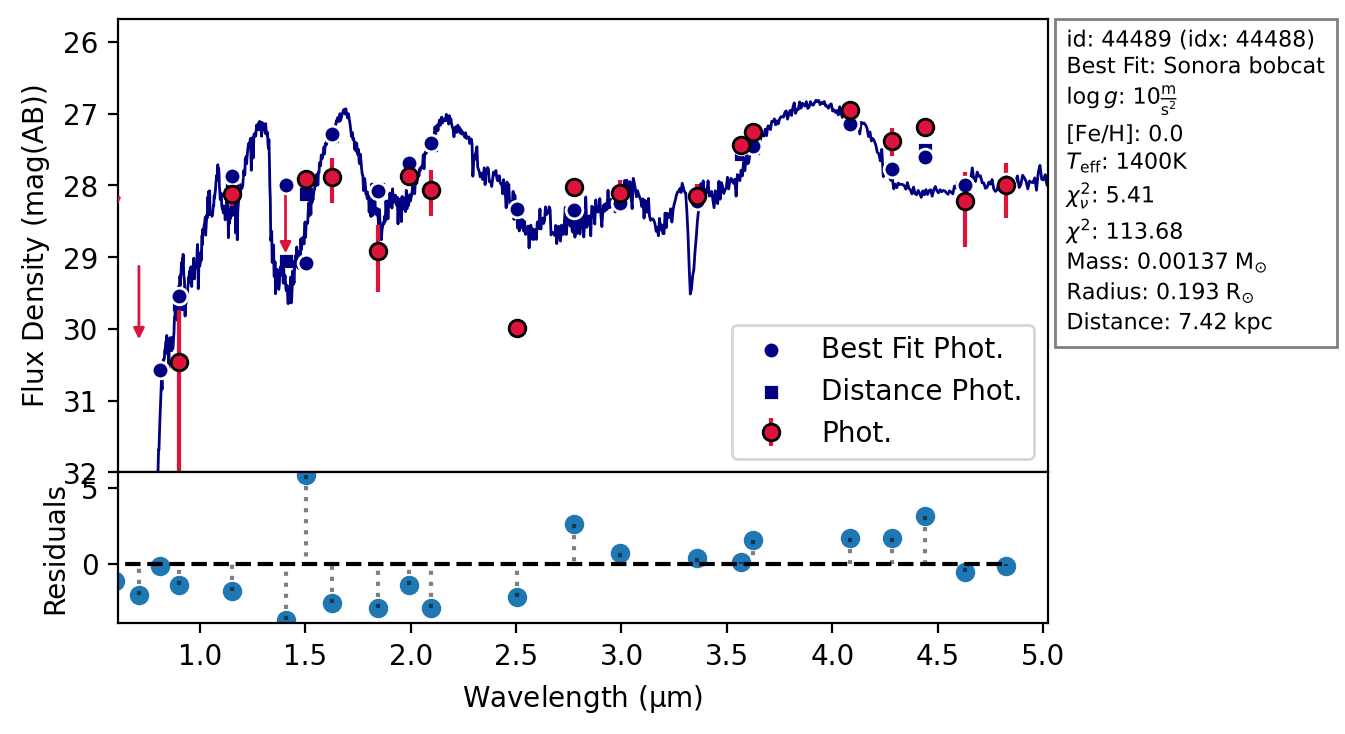

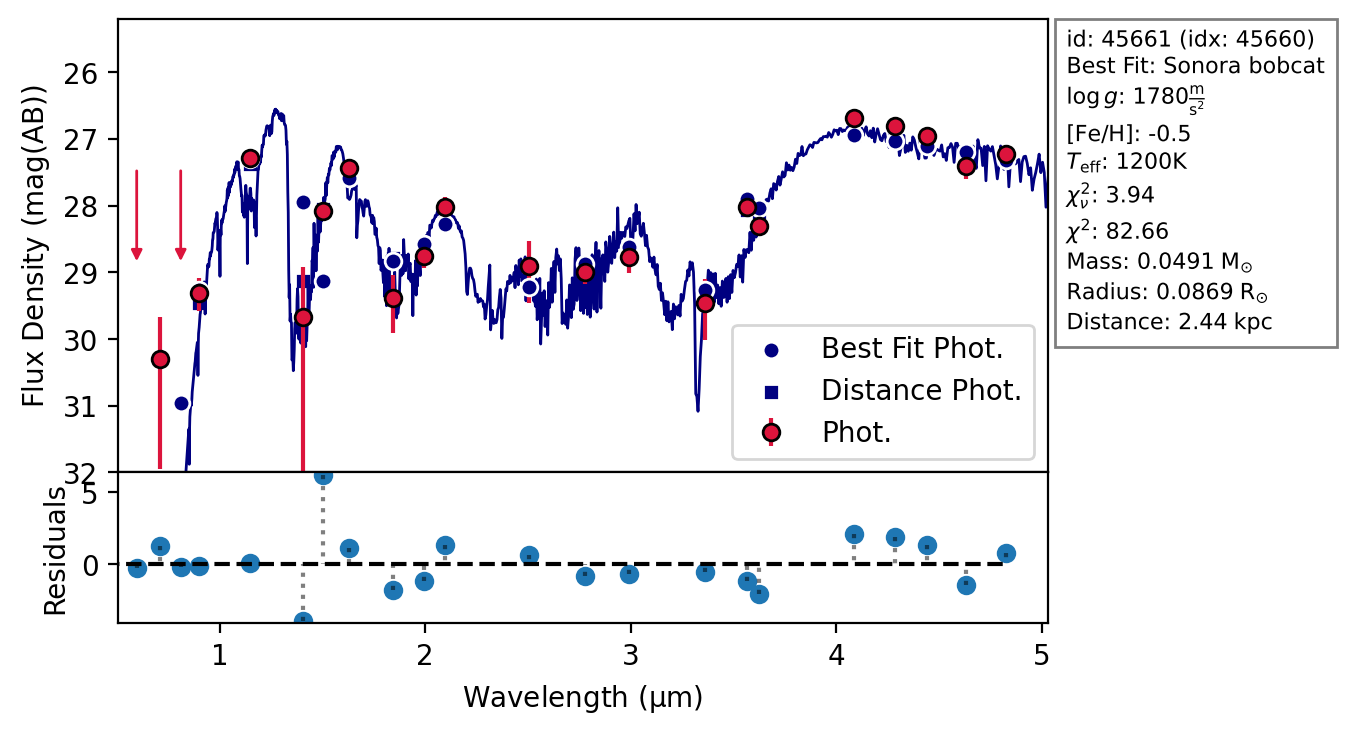

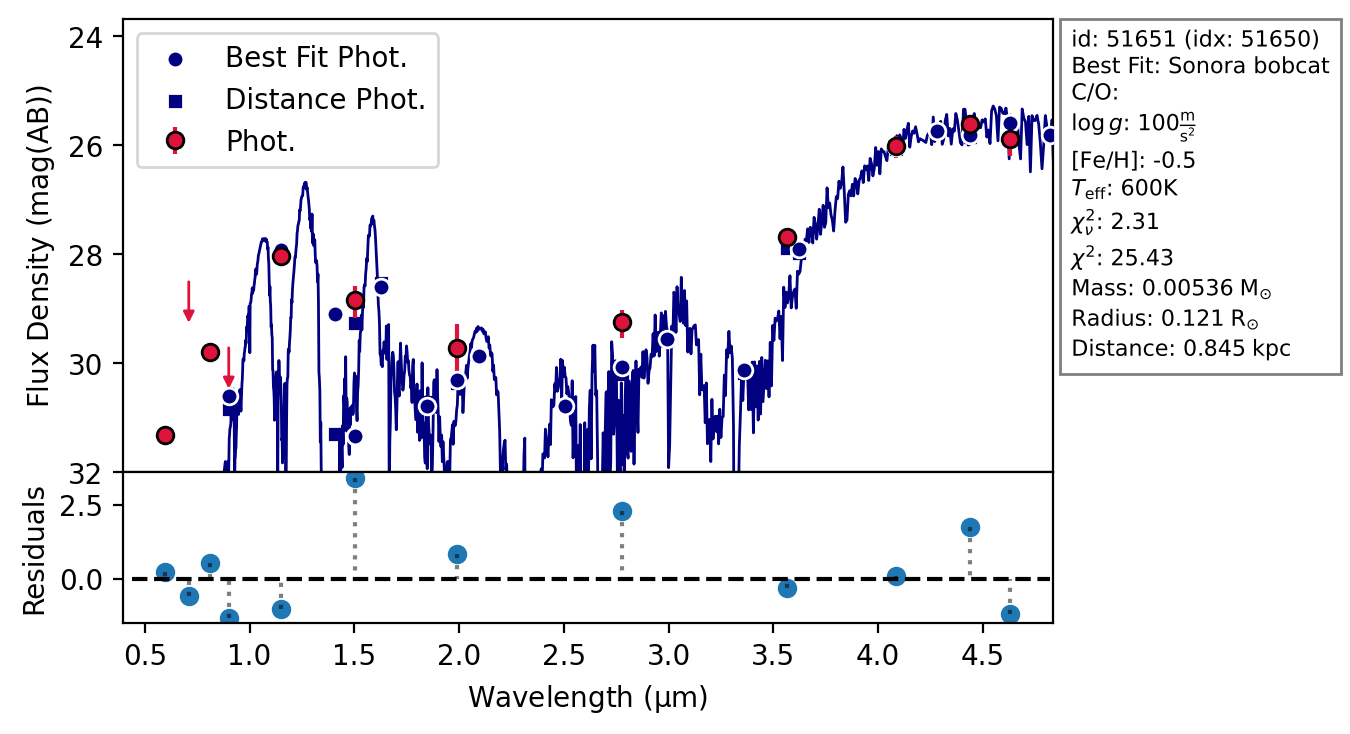

In [ ]:
%matplotlib inline

for id in table['id'][idx]:
    print(id)
    s.plot_fit(cat_id=id, flux_unit=u.ABmag, test_scale=1)

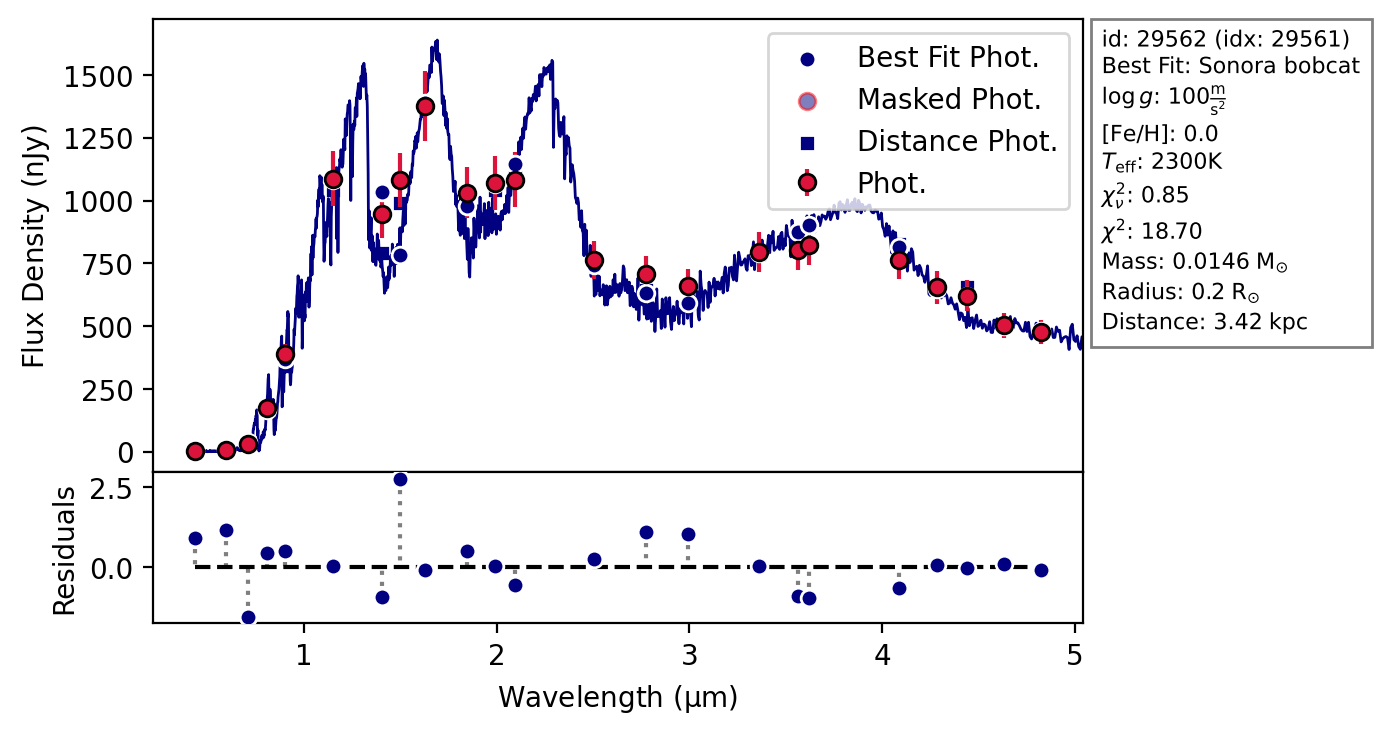

In [6]:
s.plot_fit(cat_id=29562, test_scale=1,);